# Developed by Jonathan Ojeda 7/11/2021

### This code is able to retrieve APSIM Next Gen outputs and carried out a variance decomposition analysis to identify the main contributors to the variance in selected model outputs

_**Functionality:**_ Calculate the main (ME) and total effect (TE) of a series of factors on the variability of a selected variable (in this example crop biomass).

ME explains the share of the components to crop biomass variability without interactions, 
i.e. if ME=1, the assessed factors explain the entire proportion of crop biomass variability, 
but if M<1, residuals exist which means additional factors are required to explain this variability. 
TE represents the interaction of a given factor with other factors, i.e. high TE values for a given 
factor denote high interactions of that factor with other factors, therefore, TE does not include residuals.

In [6]:
#Required packages
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker

# 1- Read APSIM output from db file

In [2]:
#Read db file
db = sqlite3.connect(r'C:\Users\jon_o\Dropbox\APSIM\VarianceDecomposition\factorial10.db')
harvest = pd.read_sql("Select * from Report",db)
harvest.rename(columns={'Maize.AboveGround.Wt':'biomass'}, inplace=True)
harvest.head()

,CheckpointID,SimulationID,Experiment,SowDate,Fertiliser,Cultivar,Site,Zone,Clock.Today,biomass,rain,drain
0,1,14,Experiment,1-oct,150,Pioneer_34K77,Dry,Field,1984-05-14 12:00:00,1719.879729,443.400000,34.700530
1,1,14,Experiment,1-oct,150,Pioneer_34K77,Dry,Field,1985-04-14 12:00:00,544.958436,272.700002,39.686612
2,1,14,Experiment,1-oct,150,Pioneer_34K77,Dry,Field,1986-04-27 12:00:00,1030.119261,511.500000,57.696995
3,1,14,Experiment,1-oct,150,Pioneer_34K77,Dry,Field,1987-06-01 12:00:00,687.424128,591.999999,128.205171
4,1,14,Experiment,1-oct,150,Pioneer_34K77,Dry,Field,1988-04-25 12:00:00,736.607115,223.900000,0.000015


# 2- Create categorical clusters for continuous variables

In [3]:
RainCluster = []
thres1=np.percentile(harvest["rain"], 33)
thres2=np.percentile(harvest["rain"], 66)

for i in harvest["rain"]:
    if i < thres1:
        RainCluster.append('Low')
    elif i > thres1 and i < thres2:
        RainCluster.append('Med')
    else:
        RainCluster.append('High')
harvest["RainCluster"] = RainCluster

# 3- Get final dataset before the analysis
* We need to create a dataframe grouping (by mean across years for long-term simulations) based on the selected variables of analysis if years are not part of the analysis.

In [4]:
data = harvest.groupby(['SowDate', 'Fertiliser', 'Cultivar','RainCluster', 'Site'], as_index=False)['biomass', 'drain'].mean().round(decimals=1)
data.head()

<ipython-input-4-83085c101fbb>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data = harvest.groupby(['SowDate', 'Fertiliser', 'Cultivar','RainCluster', 'Site'], as_index=False)['biomass', 'drain'].mean().round(decimals=1)


,SowDate,Fertiliser,Cultivar,RainCluster,Site,biomass,drain
0,1-dec,100,Dekalb_XL82,High,Dry,883.2,126.6
1,1-dec,100,Dekalb_XL82,High,Mid,1664.4,38.4
2,1-dec,100,Dekalb_XL82,High,Wet,1755.7,49.4
3,1-dec,100,Dekalb_XL82,Low,Dry,663.7,7.7
4,1-dec,100,Dekalb_XL82,Low,Mid,1106.6,0.0


# 4- Quantify the variance crontribution from selected factors for ONE OR MORE THAN ONE variable
For this example `Cultivar`,`sowDate`,`Fertiliser` and `rain` were considered.

The output of this cell is a barplot showing the ME and the TE.

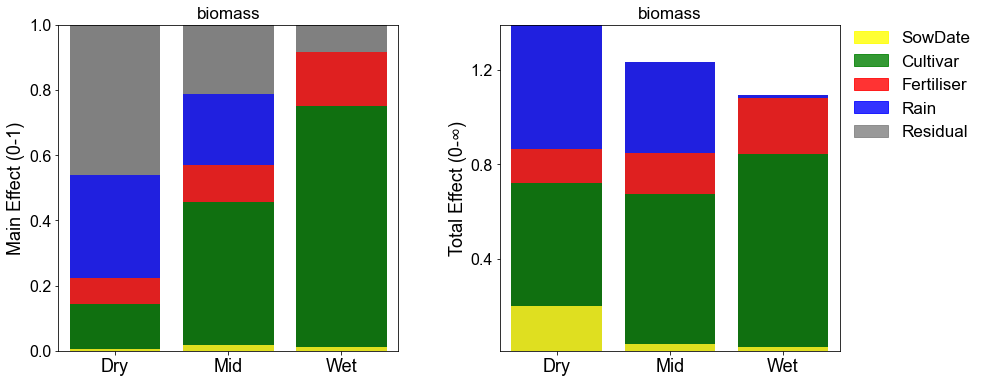

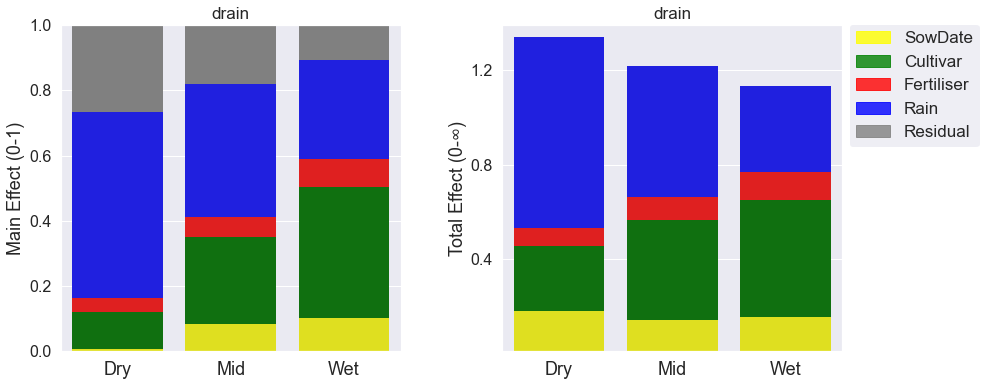

In [5]:
#Indicate in which variables we will asses the variance contribution
variables = ['biomass', 'drain']
#Here you need to add all categories for the classification variable in x axis of the graph (in this case environment)
Components=['SowDate', 'Cultivar', 'Fertiliser', 'RainCluster']
#Indicate x-axis levels
Site=['Dry', 'Mid', 'Wet']

c1,c2,c3,c4,c5=[],[],[],[],[]
for var in variables:

    for i in Site:
        GridDATA=data[data['Site']==i] #Change 'name' accordingly with the x variable for the barplot
        GridDATA=GridDATA.reset_index()
        GridDATA=GridDATA.drop( columns='Site') #Change 'name' accordingly with the x variable for the barplot
        GridDATA=GridDATA.drop( columns='index')
        totalME=[]
        totalTE=[]
        for comp in Components:
            remaining_components=['SowDate', 'Cultivar', 'Fertiliser', 'RainCluster']    
            remaining_components.remove(comp)
            TS1_df=list(GridDATA.groupby(remaining_components)[var].mean())
            TS1=1-(np.var(TS1_df)/np.var(list(GridDATA[var])))
            TOF_df=list(GridDATA.groupby(comp)[var].mean())
            TOP=(np.var(TOF_df)/np.var(list(GridDATA[var])))
            c2.append(i)
            c3.append(comp)
            c4.append(TS1)
            c5.append(TOP)
            totalME.append(TOP)
            totalTE.append(TS1)
        # print(sum(totalME))
        # print(sum(totalTE))

    Summary={'Site':c2,
             'Components': c3,
             'Total Effect':c4,
             'Main Effect':c5}
    TS_Summary=pd.DataFrame.from_dict(Summary)
    #TS_Summary.to_csv('TS_Summary.csv')

    TS_Summary1b=TS_Summary[TS_Summary["Components"]=="SowDate"]
    TS_Summary1b=TS_Summary1b.reset_index(drop=True)

    TS_Summary2b=TS_Summary[TS_Summary["Components"]=="Cultivar"]
    TS_Summary2b=TS_Summary2b.reset_index(drop=True)
    TS_Summary2b["Main Effect"]=TS_Summary2b["Main Effect"]+TS_Summary1b["Main Effect"]

    TS_Summary3b=TS_Summary[TS_Summary["Components"]=="Fertiliser"]
    TS_Summary3b=TS_Summary3b.reset_index(drop=True)
    TS_Summary3b["Main Effect"]=TS_Summary3b["Main Effect"]+TS_Summary2b["Main Effect"]

    TS_Summary4=TS_Summary[TS_Summary["Components"]=="RainCluster"]
    TS_Summary4b=TS_Summary4.reset_index(drop=True)
    TS_Summary4b["Main Effect"]=TS_Summary4b["Main Effect"]+TS_Summary3b["Main Effect"]

    TS_SummaryDic={'Site':c2,
             'Components': c3,
             'Total Effect':np.ones(len(c2)),
             'Main Effect':np.ones(len(c2))}
    TS_Summary5b=pd.DataFrame.from_dict(TS_SummaryDic)

    #######################
    #FIGURE#
    #######################
    fig = plt.figure(figsize=(14,6))

    ax = plt.subplot(1,2,1)
    sns.barplot(x = 'Site', y = 'Main Effect',data=TS_Summary5b, color = "grey", linewidth=0, ci=None)
    sns.barplot(x = 'Site', y = 'Main Effect',data=TS_Summary4b, color = "blue", linewidth=0, ci=None)
    sns.barplot(x = 'Site', y = 'Main Effect',data=TS_Summary3b, color = "red", linewidth=0, ci=None)
    sns.barplot(x = 'Site', y = 'Main Effect',data=TS_Summary2b, color = "green", linewidth=0, ci=None)
    sns.barplot(x = 'Site', y = 'Main Effect',data=TS_Summary1b, color = "yellow", linewidth=0, ci=None)
    plt.ylim([0,1])
    
    #Create legend
    yellow_patch = mpatches.Patch(color='yellow',alpha=.8,label='SowDate')
    green_patch = mpatches.Patch(color='green',alpha=.8,label='Cultivar')
    red_patch = mpatches.Patch(color='red',alpha=.8,label='Fertiliser')
    blue_patch = mpatches.Patch(color='blue',alpha=.8,label='Rain')
    grey_patch = mpatches.Patch(color='grey',alpha=.8,label='Residual')

    leg=plt.legend(handles=[yellow_patch, green_patch, red_patch, blue_patch, grey_patch], fontsize=17,
                   loc=4,ncol=1, bbox_to_anchor=[2.73, 0.6])   
    
    leg.get_frame().set_linewidth(0.0)
    plt.title(var, fontsize=17)
    plt.xlabel('')
    plt.ylabel('Main Effect (0-1)',fontsize=18)
    ax.yaxis.set_tick_params(labelsize=16)
    ax.xaxis.set_tick_params(labelsize=18)

    ######################
    ax = plt.subplot(1,2,2)
    sns.set()

    TS_Summary1=TS_Summary[TS_Summary["Components"]=="SowDate"]
    TS_Summary1=TS_Summary1.reset_index(drop=True)

    TS_Summary2=TS_Summary[TS_Summary["Components"]=="Cultivar"]
    TS_Summary2=TS_Summary2.reset_index(drop=True)
    TS_Summary2["Total Effect"]=TS_Summary2["Total Effect"]+TS_Summary1["Total Effect"]

    TS_Summary3=TS_Summary[TS_Summary["Components"]=="Fertiliser"]
    TS_Summary3=TS_Summary3.reset_index(drop=True)
    TS_Summary3["Total Effect"]=TS_Summary3["Total Effect"]+TS_Summary2["Total Effect"]

    TS_Summary4=TS_Summary[TS_Summary["Components"]=="RainCluster"]
    TS_Summary4=TS_Summary4.reset_index(drop=True)
    TS_Summary4["Total Effect"]=TS_Summary4["Total Effect"]+TS_Summary3["Total Effect"]

    sns.barplot(x = 'Site', y = 'Total Effect',data=TS_Summary4, color = "blue", linewidth=0, ci=None)
    sns.barplot(x = 'Site', y = 'Total Effect',data=TS_Summary3, color = "red", linewidth=0, ci=None)
    sns.barplot(x = 'Site', y = 'Total Effect',data=TS_Summary2, color = "green", linewidth=0, ci=None)
    sns.barplot(x = 'Site', y = 'Total Effect',data=TS_Summary1, color = "yellow", linewidth=0, ci=None)
    ax.set_ylim([0,1.4])

    plt.title(var, fontsize=17)
    plt.xlabel('')
    plt.ylabel('Total Effect (0-\u221E)',fontsize=18)
    ax.yaxis.set_tick_params(labelsize=16)
    ax.xaxis.set_tick_params(labelsize=18)
    ax.set_ylim([0.01,1.39])
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.4))
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

    plt.subplots_adjust(wspace=0.3, hspace=0)
    #plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\L.png', dpi=300, bbox_inches='tight', pad_inches=0)